# Прогнозирование распространения COVID-19

In [40]:
from datetime import datetime as date
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 8)

Воспользуемся [статьей](https://www.thelancet.com/journals/eclinm/article/PIIS2589-5370(20)30098-5/fulltext), где обсуждается прогнозирование распространения инфекции на основе взаимодействия людей.

Основные паттерны:
    <ul>
    <li>Рассматривается прогноз в пределах конкретного города, но можно и страны - в зависимости от того к каким данным имеется доступ
    <li>Население города распределяется на семь возрастных групп: 0-6; 7-14; 15-17; 18-22; 23-44; 45-64;65 лет или старше</li>
    <li>Подразумевается разделение на 4 группы социальных контактов: (1) индивидуальные домохозяйства; (2) школы, включая начальные/средние школы, а также колледжи и университеты; (3) различные физические рабочие места; и (4) общественные места и сообщества, где люди могут собираться, такие как стадионы, рынки, площади и организованные экскурсии. Каждая из групп характеризуется матрицами контактности, изображенными на рисунке ниже</li>
    </ul>

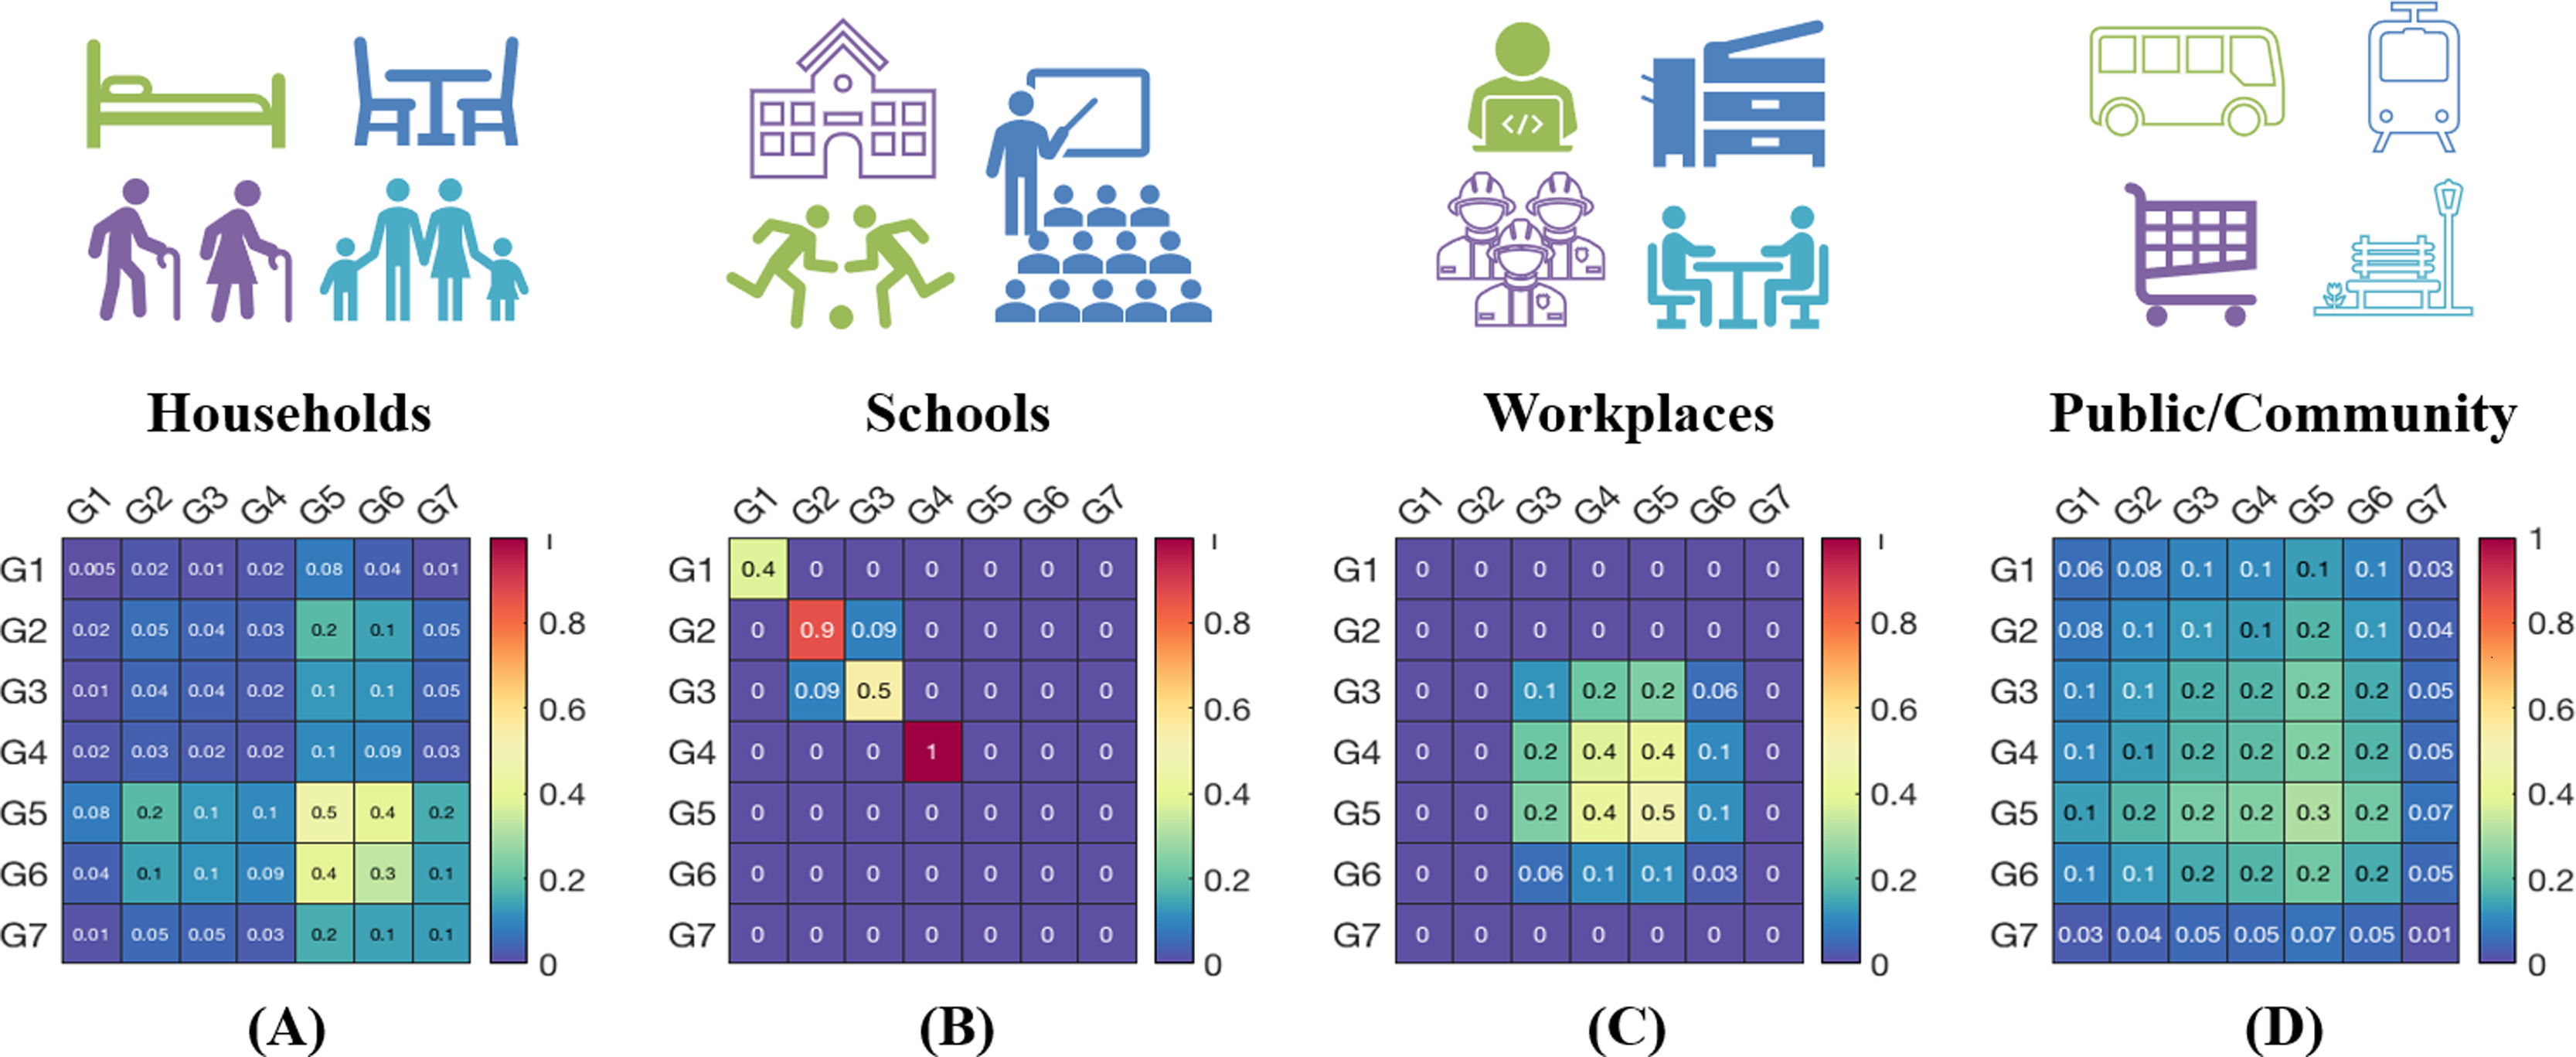

Передача болезни происходит с помощью:

\begin{equation*}
K_t   = \frac{\mu}{\gamma} S_t BCA \\
I_{t+1}   = K_t I_t
\end{equation*}

где $S_t, B, A$ и $K_t$ - матрицы 7 × 7, а $I_t$-вектор 7 × 1. В частности, $S_t$, $B$ и $A$ - диагональные матрицы с диагональными элементами  $s_{ii}^t$

### Алгоритм

In [2]:
def calculation(name):
    C = (ch * rh) + (rs * cs) + (rw * cw) + (rp * cp)
    B = np.mat(np.zeros((size, size)))
    np.fill_diagonal(B, B0 / S0)
    I_sums = [I0.sum()]
    I_kat = [np.mat(I0).reshape(size, 1)]

    for i in range(predict_days + 1):
        if i == 0:
            I_val = I0
            S_val = S0
            I_val_sum = I0
        else:
            I_val = I_val
            S_val = S_val
            I_val_sum = I_val_sum

        # фиксируем матрицу S на i-ом дне    
        S_val = S0 - I_val_sum  # создаем список диагональных элементов для матрицы S
        S = np.mat(np.zeros((size, size)))
        np.fill_diagonal(S, S_val)

        if i > 0:
            # фиксируем матрицу K на (i+1)-ом дне
            K = ((R / y) * S @ B) @ C

            # Количетсво инфицированных на (i+1)-ом дне по категориям
            I_val = K @ (I_val.reshape(size, 1))

            # Количество инфицированных по категориям
            I_kat.append(I_val)

            # Добавляем значение инфиц на (i+1) дне в итоговый массив количества инфицированных
            I_sums.append(I_val.sum())

            # Добавляем к инфиц. по категориям на i-ом шаге инфиц. на (i+1) шаге
            I_val_sum = I_val.flatten() + I_val_sum

    results_df[name] = I_sums
    for i in range(7):
        results_df_kat['%s лет' % ages[i]] = [j[i, 0] for j in I_kat]

    results_df_kat['< 40 лет'] = results_df_kat['< 6 лет'] 
                                 + results_df_kat['7-14 лет'] \
                                 + results_df_kat['15-17 лет'] \
                                 + results_df_kat['18-22 лет'] \
                                 + results_df_kat['23-39 лет']

### Входные данные

In [3]:
predict_days = 180
size = 7

# Возрастные группы
ages = np.array(['< 6', '7-14', '15-17', '18-22', '23-39', '40-60', '60 <'])

# Итоговый датафрейм с результатами
start = date(2020, 4, 12)
indexes = pd.date_range(start=start, periods=predict_days + 1)
results_df = pd.DataFrame(index=indexes)
results_df_kat = pd.DataFrame(index=indexes)

In [26]:
# Фактические цифры кол-ва подверженных зараженнию
S0 = np.array([])

# Фактические цифры кол-ва зараженных по категориям
I0 = np.array([]).T

# Матрица восприимчивых к заражению
B0 = np.array([])

In [5]:
# Households
ch = np.mat([0.005, 0.02, 0.01, 0.02, 0.08, 0.04, 0.01,
             0.02, 0.05, 0.04, 0.03, 0.2, 0.1, 0.05,
             0.01, 0.04, 0.04, 0.02, 0.1, 0.1, 0.05,
             0.02, 0.03, 0.02, 0.02, 0.1, 0.09, 0.03,
             0.08, 0.2, 0.1, 0.1, 0.5, 0.4, 0.2,
             0.04, 0.1, 0.1, 0.09, 0.4, 0.3, 0.1,
             0.01, 0.05, 0.05, 0.03, 0.2, 0.1, 0.1
             ]).reshape(size, size)

# Schools
cs = np.mat([0.4, 0, 0, 0, 0, 0, 0,
             0, 0.9, 0.09, 0, 0, 0, 0,
             0, 0.09, 0.5, 0, 0, 0, 0,
             0, 0, 0, 1, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0
             ]).reshape(size, size)

# Workplaces
cw = np.mat([0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0.4, 0.4, 0.1, 0,
             0, 0, 0, 0.4, 0.5, 0.1, 0,
             0, 0, 0, 0.1, 0.1, 0.03, 0,
             0, 0, 0, 0, 0, 0, 0
             ]).reshape(size, size)

# Public/Community
cp = np.mat([0.06, 0.08, 0.1, 0.1, 0.1, 0.1, 0.03,
             0.08, 0.1, 0.1, 0.1, 0.2, 0.1, 0.04,
             0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.05,
             0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.05,
             0.1, 0.2, 0.2, 0.2, 0.3, 0.2, 0.07,
             0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.05,
             0.03, 0.04, 0.05, 0.05, 0.07, 0.05, 0.01
             ]).reshape(size, size)


### Отрисовка по возрастам

In [27]:
#1 сценарий
y = 0.61 # Коэффициент выздоравливаемости

# весовые коэффициенты
rh = 0.31
rs = 0.0
rw = 0.048
rp = 0.029
R = 1

calculation('Текущие ограничения')

In [28]:
#2 сценарий
y = 0.61 # Коэффициент выздоравливаемости

# весовые коэффициенты
rh = 0.31
rs = 0.0
rw = 0.048 * (1 + 0.044)
rp = 0.029 * (1 + 0.05)
R = 1

calculation('Открытие парикмахерских и т.п.')

In [29]:
#3 сценарий
y = 0.61 # Коэффициент выздоравливаемости

# весовые коэффициенты
rh = 0.31
rs = 0.0
rw = 0.048 * (1 + 0.44)
rp = 0.029 * (1 + 1.04)
R = 1

calculation('Открытие ключевых отраслей')

In [30]:
#4 сценарий
y = 0.61 # Коэффициент выздоравливаемости

# весовые коэффициенты
rh = 0.31
rs = 0.24
rw = 0.048 * (1 + 0.0)
rp = 0.029 * (1 + 1.0)
R = 1

calculation('Открытие образовательных учреждений')

### Просмотр общих результатов модели

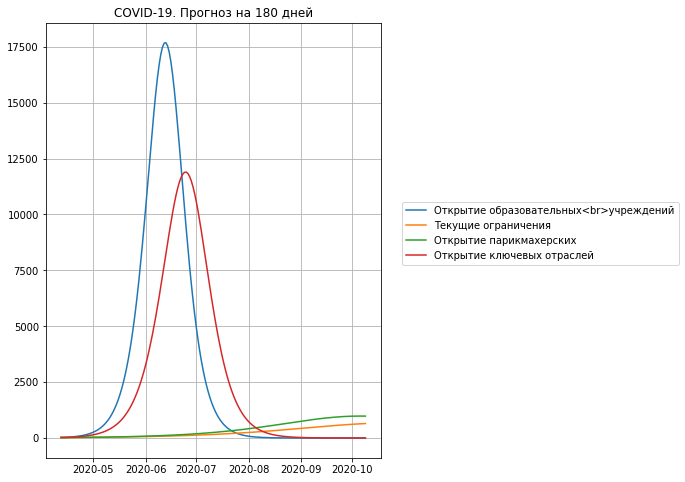

In [44]:
for i in results_df.columns:
    plt.plot(results_df.index, results_df[i], label=f'{i}')
plt.title(f'COVID-19. Прогноз на {predict_days} дней')
plt.legend(bbox_to_anchor=(1.05, 0.6))
plt.grid()